# Scaling with domain size 2D

In [1]:
from jwave.geometry import Domain
from jax import numpy as jnp
from jwave.geometry import Medium,TimeAxis,_points_on_circle, Sensors, _circ_mask
from jwave.acoustics import simulate_wave_propagation
from jwave import FourierSeries
from timeit import timeit
from jax import jit

In [8]:
N0 = 2048

In [9]:
N, dx = (N0, N0), (0.1e-3, 0.1e-3)
domain = Domain(N, dx)
sound_speed = 1500.
medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=20)

sensors_positions = (jnp.array([35]), jnp.array([40]))
sensors = Sensors(positions=sensors_positions)

mask1 = _circ_mask(N, 8, (N0//2,N0//2))
p0 = FourierSeries(jnp.expand_dims(5.*mask1, -1), domain)

In [10]:
time_axis = TimeAxis.from_medium(medium, cfl=0.3, t_end=1.998e-5)

@jit
def solver(p0):
    return simulate_wave_propagation(medium, time_axis, p0=p0, sensors=sensors)


In [11]:
_ = solver(p0)

In [12]:
%timeit solver(p0).block_until_ready()

6.37 s ± 27.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
steps = [64, 92, 128, 192, 256, 512, 784, 1024, 2048]

# Times in ms
mean_times = [64, 80, 72, 94, 95, 329, 1030, 1550, 6370]

In [15]:
!nvidia-smi

Tue Mar 15 13:54:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.54       Driver Version: 510.54       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:01:00.0  On |                  N/A |
| 64%   79C    P0    40W / 125W |   7450MiB /  8192MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
len(time_axis.to_array())

999

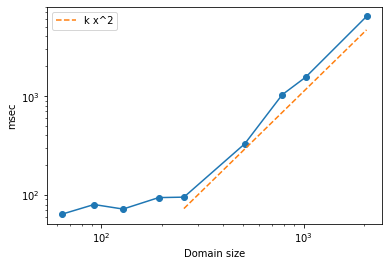

In [19]:
from matplotlib import pyplot as plt

#plt.errorbar(steps, mean_times, yerr=std_times, marker='o')
plt.plot(steps, mean_times, marker='o')
x_sq = list(map(lambda x: float(x/30)**2, steps[4:]))
plt.plot(steps[4:], x_sq, linestyle='--', label="k x^2")

plt.ylabel("msec")
plt.xlabel("Domain size")
plt.xscale("log")
plt.yscale("log")
plt.legend()